## Setup Datasets
1. image_batch['image']
2. image_batch['image_idx']

In [1]:
import src.dataloader
import torch
import pathlib

device = torch.device("cuda")

dataloader = src.dataloader.load_train_data(
    dataset_dir=pathlib.Path("C:/Users/imeho/Documents/DataSets/InstantPINF/ScalarReal"),
    split="train",
    device=torch.device("cuda"),
    frame_skip=1,
    exclude_batch_keys_from_device=["image", "image_idx"],
)
image_batch = next(iter(dataloader))
sorted_indices = torch.argsort(image_batch["image_idx"])
image_batch["image_idx"] = image_batch["image_idx"].index_select(0, sorted_indices).to(device)
image_batch["image"] = image_batch["image"].index_select(0, sorted_indices).to(device)

print(f'image shape: {image_batch["image"].shape}')
print(f'image indices shape: {image_batch["image_idx"].shape}')
print(f'image device: {image_batch["image"].device}')
print(f'image indices: {image_batch["image_idx"].device}')
memory_image = image_batch['image'].element_size() * image_batch['image'].numel()
memory_indices = image_batch['image_idx'].element_size() * image_batch['image_idx'].numel()
print(f'Memory of image: {memory_image / 1024 / 1024:.2f} MB')
print(f'Memory of indices: {memory_indices / 1024 / 1024:.2f} MB')

Caching all 480 images.

Output()

image shape: torch.Size([480, 1920, 1080, 3])
image indices shape: torch.Size([480])
image device: cuda:0
image indices: cuda:0
Memory of image: 11390.62 MB
Memory of indices: 0.00 MB


## Setup Hash Encoder
1. xyzt_encoder(xyzt)

In [2]:
import src.encoder
import taichi as ti
import numpy as np

ti.init(arch=ti.cuda)
xyzt_encoder = src.encoder.HashEncoderHyFluid(
    min_res=np.array([16, 16, 16, 16]),
    max_res=np.array([256, 256, 256, 128]),
    num_scales=16,
    max_params=2 ** 19,
)
xyzt_encoder.to(device)

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.11.0
[Taichi] Starting on arch=cuda


HashEncoderHyFluid()

## Setup Model & Optimizer
1. mlp(xyzt_encoded)
2. learned_rgb
3. optimizer

In [3]:
import nerfstudio.field_components.mlp
import src.radam

mlp = nerfstudio.field_components.mlp.MLP(
    in_dim=xyzt_encoder.num_scales * xyzt_encoder.features_per_level,
    num_layers=2,
    layer_width=64,
    out_dim=1,
    out_activation=torch.nn.ReLU(),
).to(device)
learned_rgb = torch.nn.Parameter(torch.tensor([0.0], device=device))

grad_vars = list(mlp.parameters()) + [learned_rgb]
embedding_params = list(xyzt_encoder.parameters())

optimizer = src.radam.RAdam([
    {'params': grad_vars, 'weight_decay': 1e-6},
    {'params': embedding_params, 'eps': 1e-15}
], lr=0.01, betas=(0.9, 0.99))

## Setup Ray Sampler & Collider

In [4]:
import nerfstudio.model_components.ray_generators
import nerfstudio.model_components.ray_samplers
import nerfstudio.data.pixel_samplers
import nerfstudio.model_components.scene_colliders

pixel_sampler = nerfstudio.data.pixel_samplers.PixelSamplerConfig(num_rays_per_batch=1024).setup()
ray_generator = nerfstudio.model_components.ray_generators.RayGenerator(dataloader.dataset.cameras).to(device)
uniform_sampler = nerfstudio.model_components.ray_samplers.UniformSampler(num_samples=192).to(device)
near_far_collider = nerfstudio.model_components.scene_colliders.NearFarCollider(near_plane=1.1, far_plane=1.5).to(
    device)

## Optimization Loop

In [ ]:
import time
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict
import nerfstudio.model_components.losses

raw2alpha = lambda raw, dists, act_fn=torch.nn.functional.relu: 1. - torch.exp(-act_fn(raw) * dists)
rgb_loss = nerfstudio.model_components.losses.MSELoss()
boundary_frames = torch.tensor([119, 239, 359, 479], dtype=torch.int32, device=device)


def perturb_frames_sample(image_batch, all_frames, batch):
    sample_image = batch['image']
    sample_idx = batch['indices'].float()

    video_starts = [0] + list(torch.cumsum(torch.tensor(all_frames[:-1]), dim=0).numpy())
    video_ends = [start + frames - 1 for start, frames in zip(video_starts, all_frames)]

    images = image_batch['image']
    image_idx = image_batch['image_idx']
    num_samples = sample_image.shape[0]

    for i in range(num_samples):
        current_frame_idx = int(sample_idx[i, 0].item())

        # 检查是否为视频的第一个或最后一个帧
        is_first_or_last_frame = any(
            current_frame_idx == video_starts[j] or current_frame_idx == video_ends[j]
            for j in range(len(all_frames))
        )
        if is_first_or_last_frame:
            continue

        current_height_idx = int(sample_idx[i, 1].item())
        current_width_idx = int(sample_idx[i, 2].item())
        perturb_value = (torch.rand(1).item() - 0.5)

        if perturb_value > 0:
            # 获取下一帧的索引
            next_frame_idx = torch.where(image_idx == (current_frame_idx + 1))[0].item()
            assert image_idx[next_frame_idx] == (current_frame_idx + 1)
            weight_curr = (0.5 - perturb_value) / 0.5
            weight_next = perturb_value / 0.5
            sample_image[i] = weight_curr * sample_image[i] + weight_next * images[
                next_frame_idx, current_height_idx, current_width_idx]
            sample_idx[i, 0] = current_frame_idx + perturb_value

        elif perturb_value < 0:
            # 获取前一帧的索引
            prev_frame_idx = torch.where(image_idx == (current_frame_idx - 1))[0].item()
            assert image_idx[prev_frame_idx] == (current_frame_idx - 1)
            weight_curr = (0.5 + perturb_value) / 0.5
            weight_prev = -perturb_value / 0.5
            sample_image[i] = weight_curr * sample_image[i] + weight_prev * images[
                prev_frame_idx, current_height_idx, current_width_idx]
            sample_idx[i, 0] = current_frame_idx + perturb_value

    batch['image'] = sample_image
    batch['indices'] = sample_idx


def interpolate_frame(in_image_batch, boundary_frames, in_batch):
    current_frames = in_batch['indices'][:, 0]
    next_frames = current_frames + 1
    skip_indices = torch.isin(current_frames, boundary_frames)
    y_indices = in_batch['indices'][:, 1]
    z_indices = in_batch['indices'][:, 2]

    # 获取当前帧和下一帧的像素值
    current_pixels = in_image_batch['image'][current_frames, y_indices, z_indices]
    next_pixels = in_image_batch['image'][torch.where(skip_indices, current_frames, next_frames), y_indices, z_indices]

    # 随机插值系数
    random_coeff = torch.rand(current_frames.shape[0], 1, device=device)
    random_coeff_expanded = random_coeff.expand(-1, 3)

    # 计算插值后的像素值
    interpolated_pixels = current_pixels * (1 - random_coeff_expanded) + next_pixels * random_coeff_expanded

    # 计算插值后的帧数，skip_indices 的帧保持原值
    interpolated_indices = torch.where(skip_indices.unsqueeze(-1),
                                       current_frames.unsqueeze(-1).float(),
                                       current_frames.unsqueeze(-1).float() + random_coeff)
    interpolated_indices = interpolated_indices % 120
    return interpolated_pixels, interpolated_indices

100%|██████████| 100/100 [20:59<00:00, 12.59s/it]


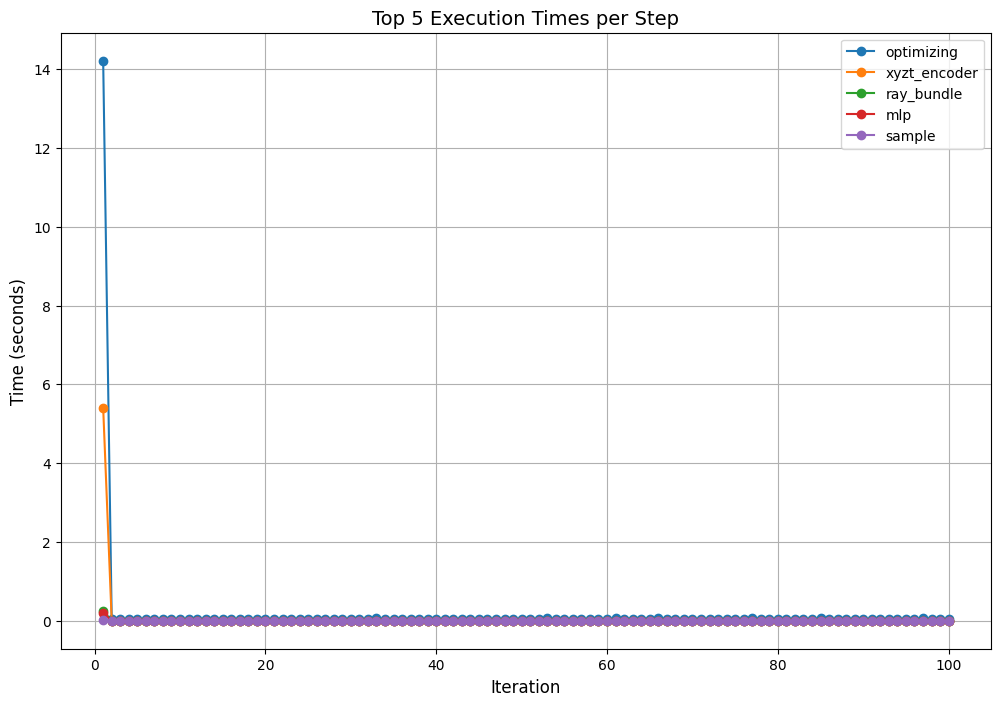

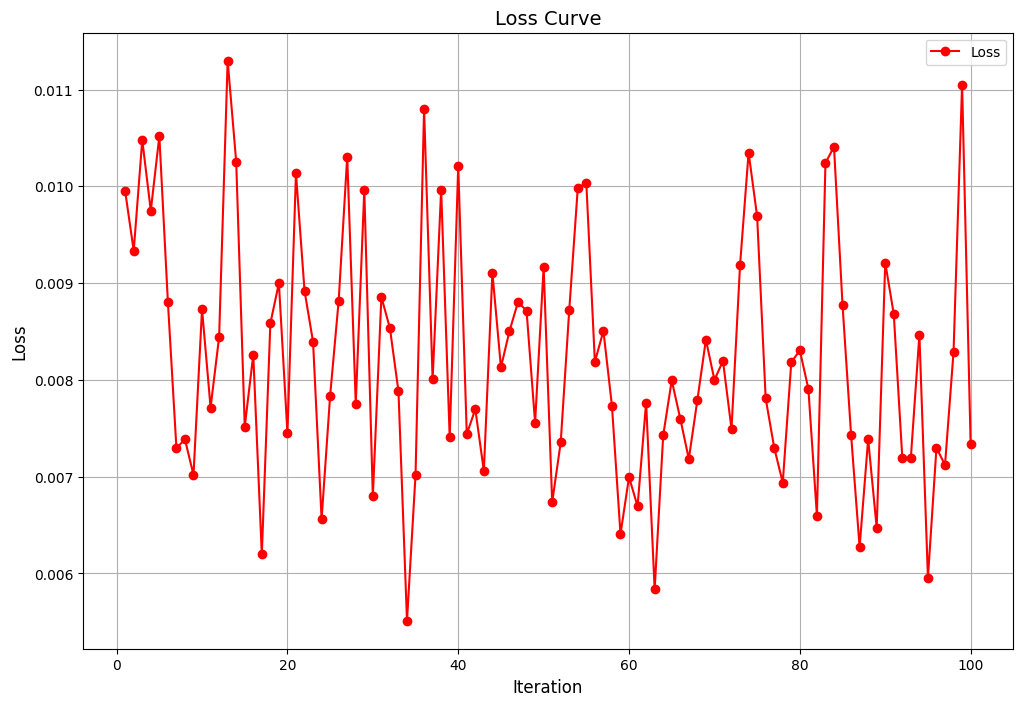

In [5]:
# 定义一个字典存储每句代码的执行时间
execution_times = defaultdict(list)
# 用于记录每次循环的 loss 值
loss_values = []

# 模拟循环任务
for i in tqdm.tqdm(range(100)):
    # 记录每一步的执行时间
    start = time.time()
    batch = pixel_sampler.sample(image_batch)
    execution_times["sample"].append(time.time() - start)

    start = time.time()
    ray_bundle = near_far_collider(ray_generator(batch['indices']))
    execution_times["ray_bundle"].append(time.time() - start)

    start = time.time()
    ray_samples_uniform = uniform_sampler(ray_bundle)
    execution_times["ray_samples_uniform"].append(time.time() - start)

    start = time.time()
    positions = ray_samples_uniform.frustums.get_positions()
    execution_times["get_positions"].append(time.time() - start)

    start = time.time()
    interpolated_pixels, interpolated_indices = interpolate_frame(image_batch, boundary_frames, batch)
    execution_times["perturb_frames_sample"].append(time.time() - start)

    start = time.time()
    frames_expanded = interpolated_indices.unsqueeze(1).expand(-1, positions.size(1), -1)  # (4096, 192, 1)
    xyzt = torch.cat([positions, frames_expanded], dim=-1)  # (4096, 192, 4)
    xyzt_flat = xyzt.reshape(-1, 4)
    execution_times["xyzt"].append(time.time() - start)

    start = time.time()
    xyzt_encoded = xyzt_encoder(xyzt_flat)
    execution_times["xyzt_encoder"].append(time.time() - start)

    start = time.time()
    raw_flat = mlp(xyzt_encoded)
    execution_times["mlp"].append(time.time() - start)

    start = time.time()
    raw = raw_flat.reshape(xyzt.shape[0], xyzt.shape[1], raw_flat.shape[-1])
    execution_times["raw_reshape"].append(time.time() - start)

    start = time.time()
    dists = ray_samples_uniform.deltas
    rgb = torch.ones(3, device=device) * (0.6 + torch.tanh(learned_rgb) * 0.4)
    alpha = raw2alpha(raw[..., -1], dists[..., -1])
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=device), 1. - alpha + 1e-10], -1),
                                    -1)[:, :-1]
    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    execution_times["raw2alpha"].append(time.time() - start)

    start = time.time()
    loss = rgb_loss(rgb_map, batch['image'])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_lrate = 5e-4 * (0.1 ** (i / 250))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate
    execution_times["optimizing"].append(time.time() - start)

    # 记录 loss 值
    loss_values.append(loss.item())

In [6]:

def replace_outliers(data, threshold=2.0):
    """
    检测并替换显著高的值
    data: list，输入的数据列表
    threshold: float，超过均值的标准差倍数阈值
    """
    data = np.array(data, dtype=np.float32)
    mean = np.mean(data)
    std = np.std(data)

    # 找到需要替换的索引
    outliers = np.abs(data - mean) > threshold * std

    # 替换为相邻的均值
    for idx in np.where(outliers)[0]:
        if idx == 0:  # 边界情况：第一个元素
            data[idx] = data[idx + 1]
        elif idx == len(data) - 1:  # 边界情况：最后一个元素
            data[idx] = data[idx - 1]
        else:  # 中间情况
            data[idx] = (data[idx - 1] + data[idx + 1]) / 2.0

    return data

# 对执行时间进行清洗
cleaned_execution_times = {
    key: replace_outliers(times) for key, times in execution_times.items()
}

# 对 loss 曲线进行清洗
cleaned_loss_values = replace_outliers(loss_values)

# 再次计算平均耗时并排序
avg_execution_times = {
    key: sum(times) / len(times) for key, times in cleaned_execution_times.items()
}
sorted_avg_times = sorted(avg_execution_times.items(), key=lambda x: x[1], reverse=True)

# 获取平均耗时 Top 5 的步骤
top5_keys = [item[0] for item in sorted_avg_times[:5]]

# 绘制清洗后的折线图
plt.figure(figsize=(12, 8))
for key in top5_keys:
    plt.plot(range(1, len(cleaned_execution_times[key]) + 1), cleaned_execution_times[key], label=key, marker='o')

# 设置图表标题和轴标签
plt.title("Top 5 Execution Times per Step (Cleaned)", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 绘制清洗后的 loss 曲线
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(cleaned_loss_values) + 1), cleaned_loss_values, label="Loss (Cleaned)", color="red", marker='o')
plt.title("Loss Curve (Cleaned)", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import nerfstudio.data.utils.dataloaders

eval_dataloader = nerfstudio.data.utils.dataloaders.RandIndicesEvalDataloader(input_dataset=dataloader.dataset)
camera, batch = next(eval_dataloader)
camera = camera.to(device)
# batch['image'] = batch['image'].to(device)
camera_ray_bundle = near_far_collider(camera.generate_rays(camera_indices=0, keep_shape=True))

In [ ]:
torch.cuda.empty_cache()
num_rays = len(camera_ray_bundle)
res = []
for i in range(0, num_rays, 4096):
    start_idx = i
    end_idx = i + 4096
    ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
    camera_ray_samples_uniform = uniform_sampler(ray_bundle.flatten())
    camera_positions = camera_ray_samples_uniform.frustums.get_positions()
    shape = list(camera_positions.shape)
    shape[-1] = 1
    camera_frames_expanded = torch.full(shape, batch['image_idx'], device=device)
    camera_xyzt = torch.cat((camera_positions, camera_frames_expanded), dim=-1)
    camera_xyzt_flat = camera_xyzt.reshape(-1, 4)
    camera_xyzt_encoded = xyzt_encoder(camera_xyzt_flat)
    camera_raw_flat = mlp(camera_xyzt_encoded)
    camera_raw = camera_raw_flat.reshape(camera_xyzt.shape[0], camera_xyzt.shape[1], camera_raw_flat.shape[-1])
    camera_dists = camera_ray_samples_uniform.deltas
    camera_rgb = torch.ones(3, device=device) * (0.6 + torch.tanh(learned_rgb) * 0.4)
    camera_alpha = raw2alpha(camera_raw[..., -1], camera_dists[..., -1])
    camera_weights = camera_alpha * torch.cumprod(torch.cat([torch.ones((camera_alpha.shape[0], 1), device=device), 1. - camera_alpha + 1e-10], -1),
                                                  -1)[:, :-1]
    camera_rgb_map = torch.sum(camera_weights[..., None] * camera_rgb, -2)
    res.append(camera_rgb_map)